In [85]:
# Import relevant libraries

%reload_ext autoreload
%autoreload 2

from sys import path
# Add the path to the src folder
path.append('src')

# Base flatland environment
from flatland.envs.line_generators import SparseLineGen
from flatland.envs.malfunction_generators import (
    MalfunctionParameters,
    ParamMalfunctionGen,
)
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import SparseRailGen
from flatland_cutils import TreeObsForRailEnv as TreeCutils
from flatland.envs.observations import GlobalObsForRailEnv

from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.distance_map import DistanceMap
import flatland.envs.rail_env_shortest_paths as sp

# Observation utils and custom policies
from observation_utils import *
from models import *
from deep_model_policy import DeepPolicy, PolicyParameters
from impl_config import FeatureParserConfig as fp

# Training and testing
from training import train_agent
import test_utils

# Visualization
from flatland.utils.rendertools import RenderTool

# Miscellaneous
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t
import time
import pickle

In [43]:
# Plotting parameters
plt.rc('figure', dpi = 400, figsize = (15,8))
plt.rc('font',size = 12, weight = 500)
plt.rc('lines', linewidth = 2)
colors = plt.cycler('color',
    ['#e63946', '#a1c349', '#3399cc', '#ff9ebb', '#fcd581', '#C2BBF0', '#ccee66', '#f27f34', '#006699', '#6a853f'])
    # Red, green, blue, pink, yellow, purple, light green, orange, dark blue, dark green
plt.rc('axes', facecolor='#FAFAFA', edgecolor='C3C3C3', axisbelow=True, grid = 'true', prop_cycle=colors)

## Shortest path policy baseline

In [2]:
# Create the environment

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2, # Only one agent
    obs_builder_object=GlobalObsForRailEnv(),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

/Users/romaindufly/miniforge3/lib/python3.9/site-packages/flatland/utils/rendertools.py:397: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  warnings.warn(


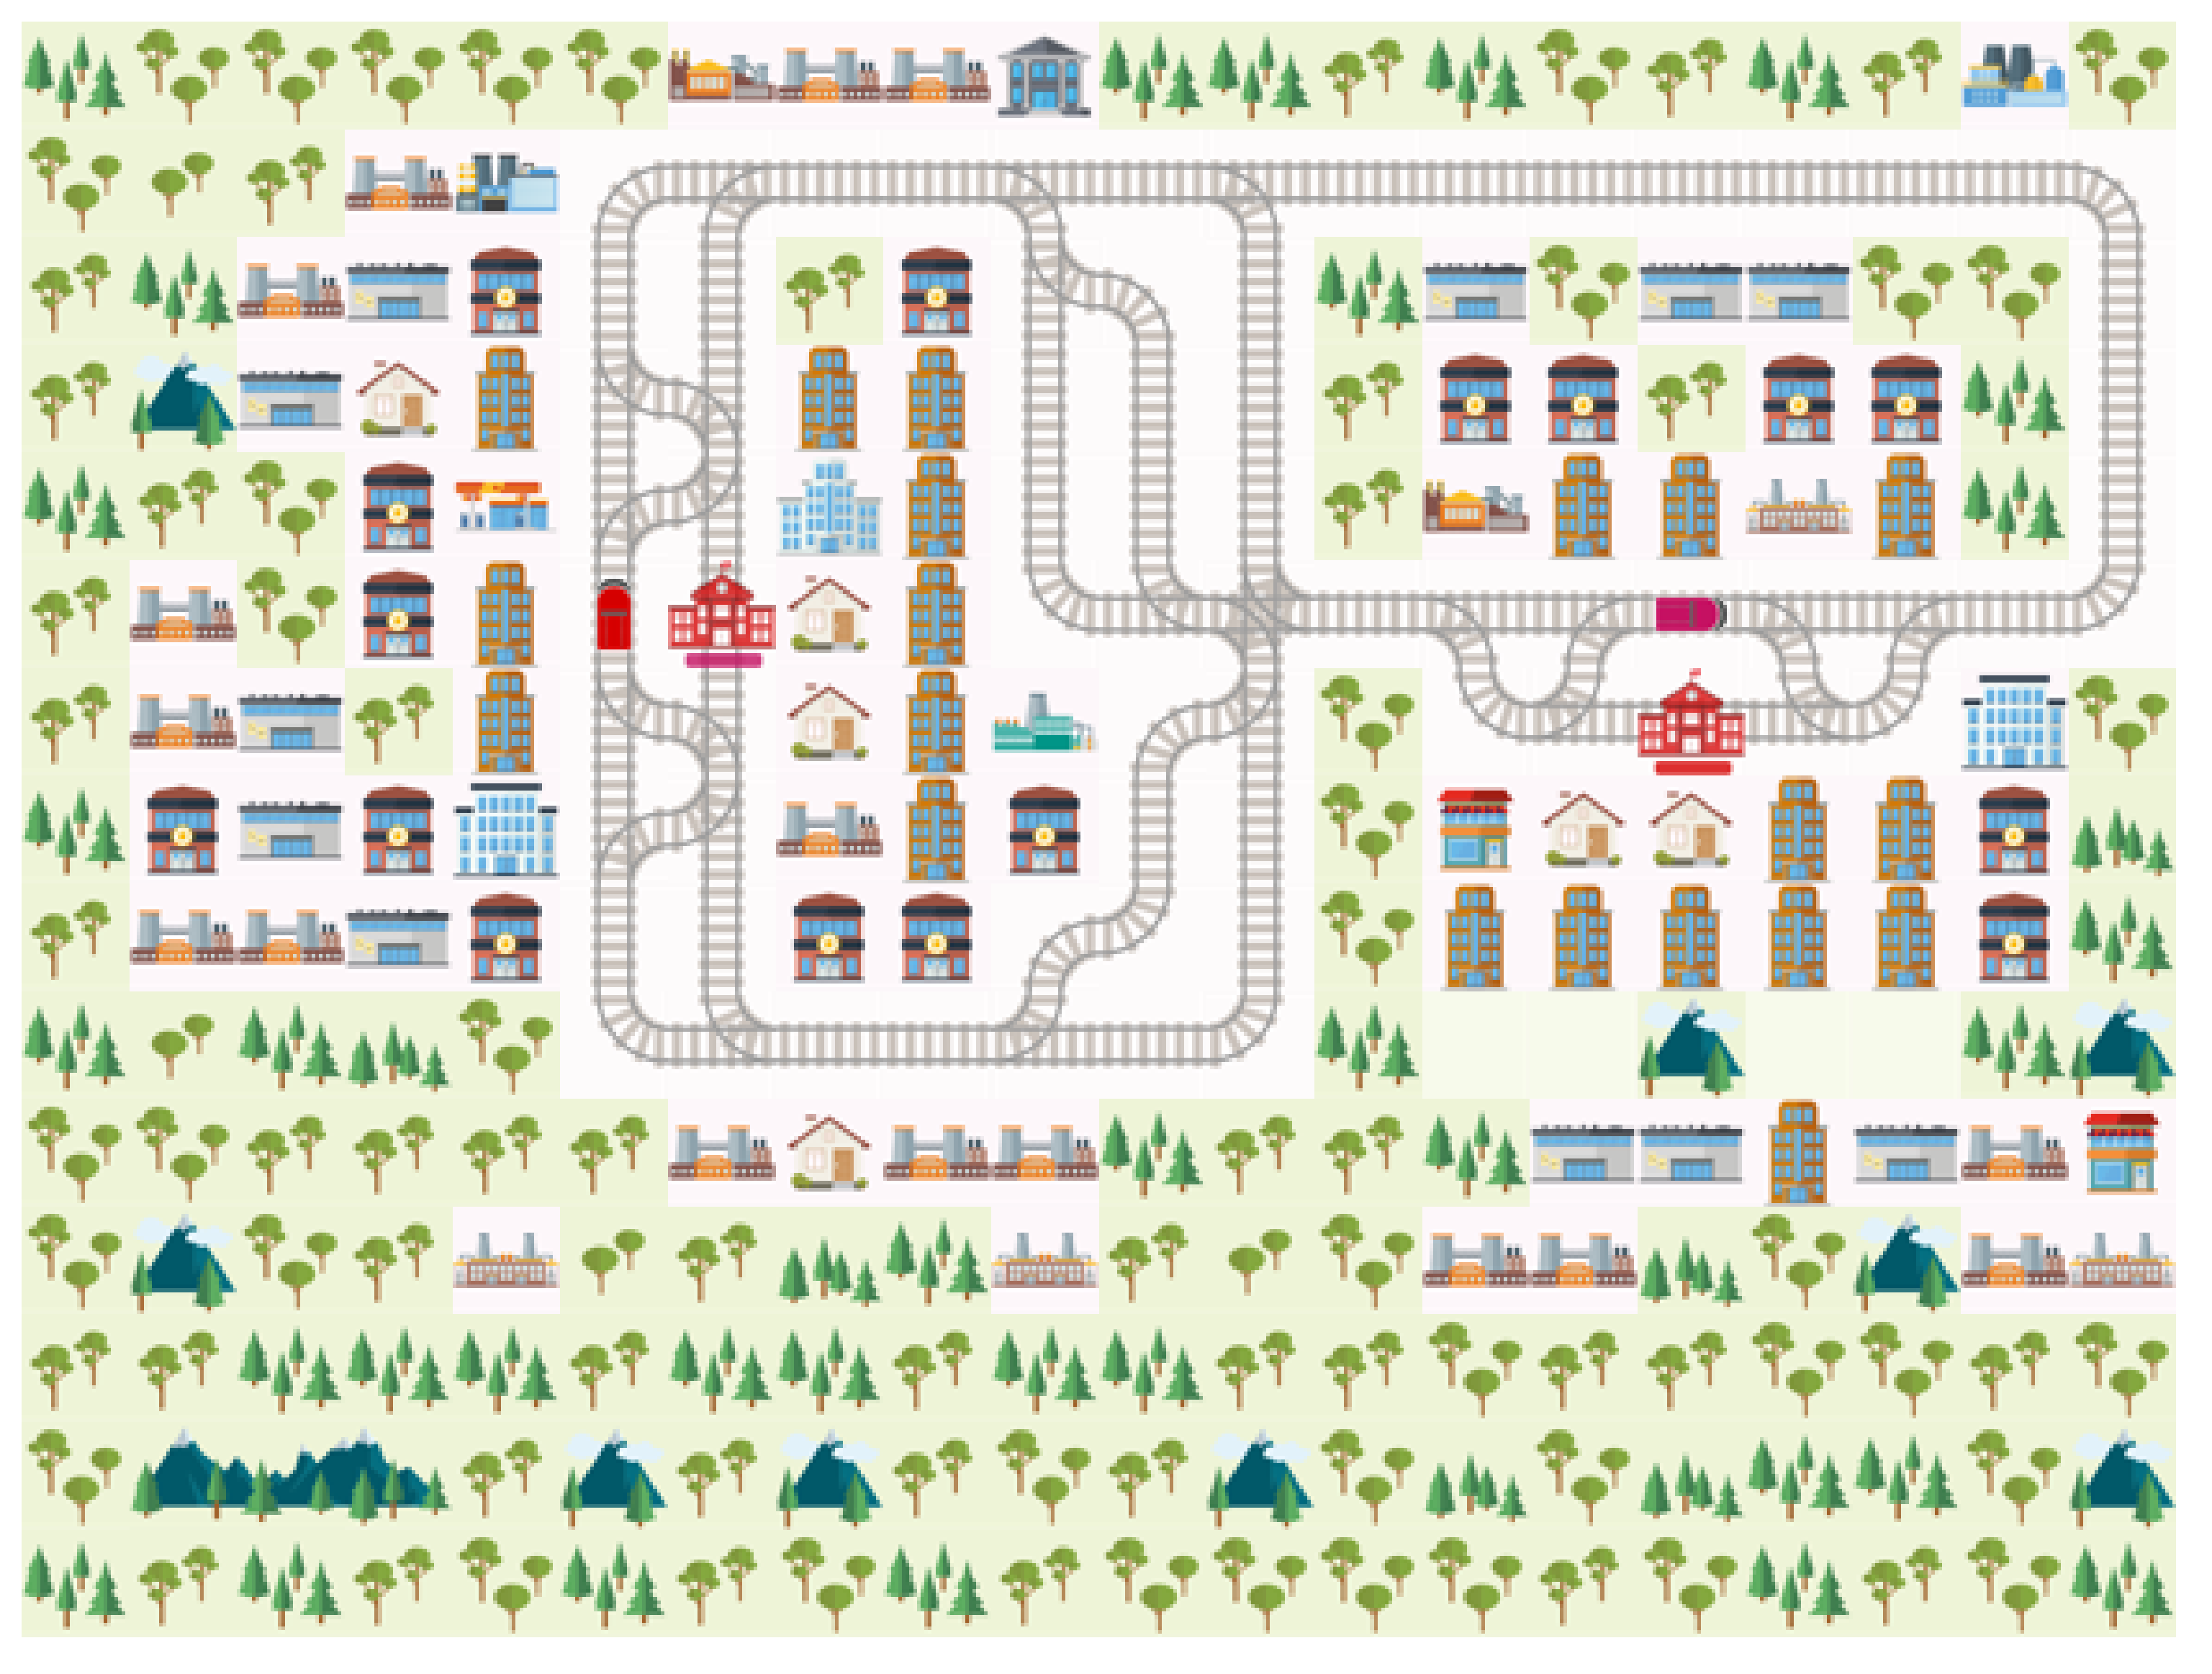

In [3]:
# First basic rendering with inactive agents

env.reset()
env_renderer = RenderTool(env)
image = env_renderer.render_env(return_image=True, show_inactive_agents=True)

plt.figure(figsize=(20, 10), dpi=300)
plt.axis('off')
plt.imshow(image)
plt.show()

In [4]:
# Display information on the environment (agents and their timetable, start position, etc)

for a in env.agents:
    print("Initial agent position: ", a.initial_position)
    print("Initial agent direction: ", a.initial_direction)
    print("Initial agent target: ", a.target)
    # ...

Initial agent position:  (5, 15)
Initial agent direction:  1
Initial agent target:  (5, 6)
Initial agent position:  (5, 5)
Initial agent direction:  0
Initial agent target:  (6, 15)


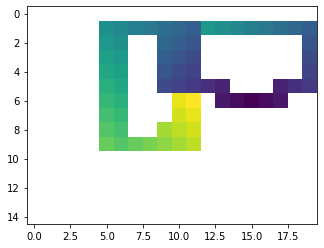

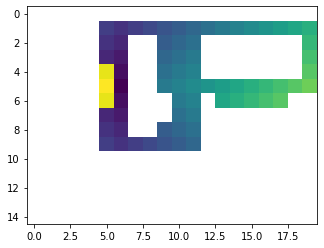

{0: 2, 1: 2}


In [5]:
# Print distance maps and test the shortest path function

env.reset()

def get_shortest_paths(env, vis=False):
    distance_map = DistanceMap(env.agents, env.width, env.height)
    distance_map.reset(env.agents, env.rail)
    distance_map.get()

    # Visualize the distance map
    if vis:
        sp.visualize_distance_map(distance_map, 0)
        sp.visualize_distance_map(distance_map, 1)

    shortest_paths = sp.get_shortest_paths(distance_map)
    for handle in shortest_paths.keys():
        if len(shortest_paths) <= 1:
            shortest_paths[handle] = 2
        elif env.agents[handle].position is None:
            shortest_paths[handle] = 2 # Forward = start moving in the map
        else:
            next_cell = shortest_paths[handle][1] # Next cell to visit
            shortest_paths[handle] = sp.get_action_for_move(env.agents[handle].position, 
                                                        env.agents[handle].direction,
                                                        next_cell.position,
                                                        next_cell.direction,
                                                        env.rail)
    return shortest_paths

# Test the shortest path function
actions = get_shortest_paths(env, vis=True)
print(actions)

Initial agent position:  (7, 25)
Initial agent direction:  2
Initial agent target:  (27, 29)
Step 0
Actions {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 1
Actions {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 2
Actions {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 3
Actions {0: 2, 1: 2, 2: 2, 3: <RailEnvActions.MOVE_FORWARD: 2>, 4: 2, 5: 2, 6: 2, 7: 2}
Step 4
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: <RailEnvActions.MOVE_FORWARD: 2>, 4: 2, 5: 2, 6: 2, 7: 2}
Step 5
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: <RailEnvActions.MOVE_FORWARD: 2>, 4: 2, 5: 2, 6: 2, 7: 2}
Step 6
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: <RailEnvActions.MOVE_FORWARD: 2>, 4: 2, 5: <RailEnvActions.MOVE_FORWARD: 2>, 6: 2, 7: 2}
Step 7
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: <RailEnvActions.MOVE_FORWARD: 2>, 4: 2, 5: <RailEnvActions.MOVE_FORWARD: 2>, 6: 2, 7: 2}
Step 8
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FO

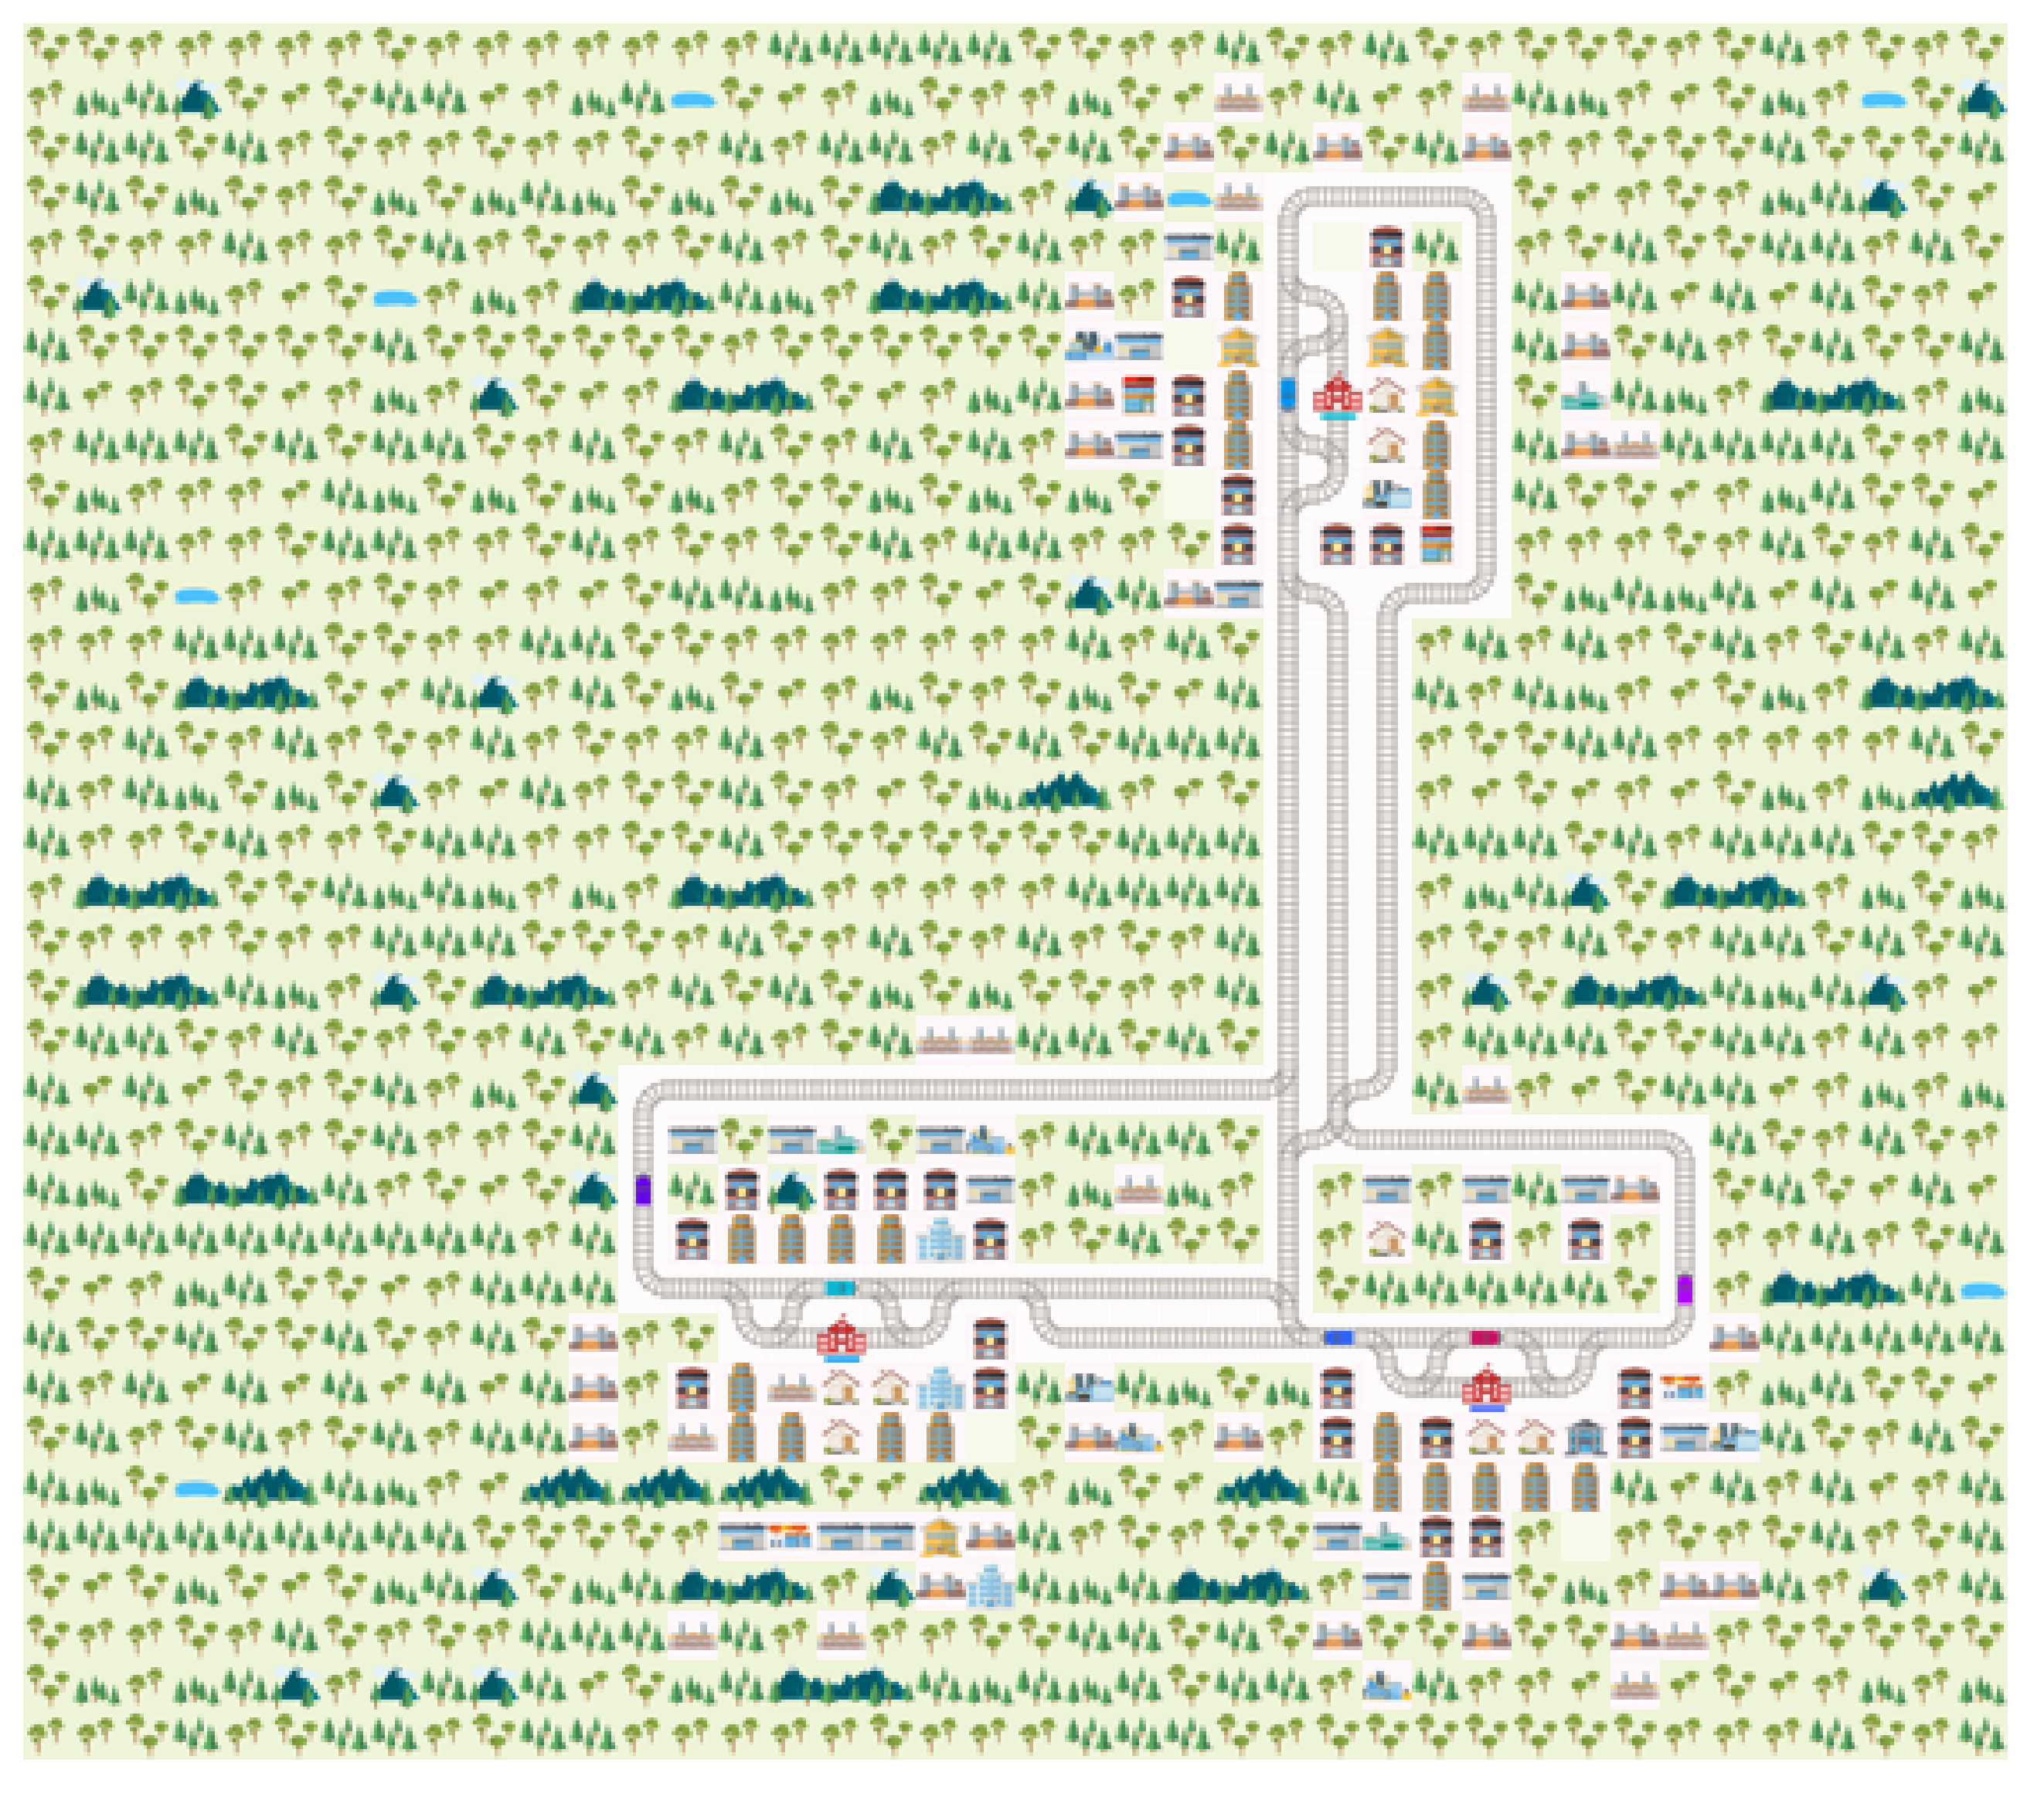

In [6]:
# Implement the shortest path policy for the agents

class SingleAgentShortest(TreeObsForRailEnv):
    '''Implements shortest path observation for the agents.'''
    def __init__(self):
        super().__init__(max_depth=0)

    def reset(self):
        super().reset()

    def get(self, handle):
        return get_shortest_paths(self.env)[handle]

# Create the environment
env = RailEnv(
    width=40,
    height=35,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=3,  # Number of cities
        grid_mode=False,
        max_rails_between_cities=1,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.},
        seed=0,  # Random seed
        ),
    number_of_agents=8,
    obs_builder_object=SingleAgentShortest(),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

obs, info = env.reset()
# Print initial position for agent 0
a = env.agents[0]
print("Initial agent position: ", a.initial_position)
print("Initial agent direction: ", a.initial_direction)
print("Initial agent target: ", a.target)

# Step loop
for step in range(10):
    actions = {}
    for handle in env.get_agent_handles():
        actions[handle] = obs[handle]
    print("Step", step)
    print("Actions", actions)
    obs, all_rewards, done, _ = env.step(actions)

# Agent's info for agent 0
print(a)
print(obs[a.handle])

# Render the final environment
env_renderer = RenderTool(env)
image = env_renderer.render_env(return_image=True, show_inactive_agents=True)
plt.figure(figsize=(20, 10), dpi=300)
plt.axis('off')
plt.imshow(image)
plt.show()

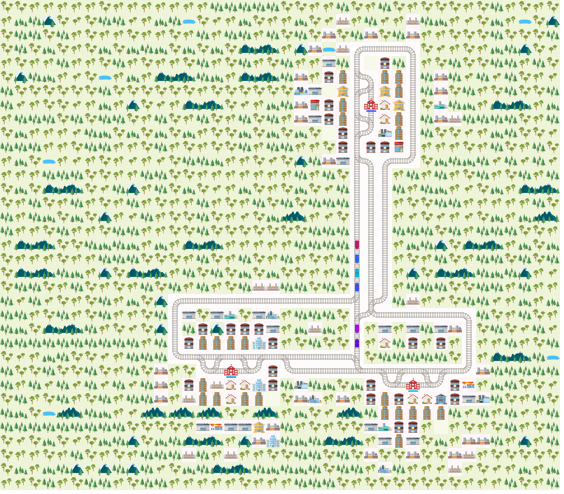

In [14]:
# Step loop with video rendering, shortest path policy

from test_utils import RenderWrapper

obs, info = env.reset()
env_renderer = RenderWrapper(env, True, False)

for step in range(100):
    actions = {}
    for handle in env.get_agent_handles():
        actions[handle] = obs[handle]
    obs, all_rewards, done, _ = env.step(actions)
    env_renderer.render()

## Custom deep policies

### DuelingQNetwork

In [77]:
%reload_ext autoreload
%autoreload 2

policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=32, gamma=0.99, tau=4e-3, 
                                 lr=6e-4, update_every=2, use_gpu=True)
observation_tree_depth = 3
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2,
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes

model = DuelingQNetwork(state_size, policy_params.action_size)
policy = DeepPolicy(model, policy_params)

# Test the policy output
obs, info = env.reset()

# Get the state by normalizing the observation
agent_obs = [None] * env.get_num_agents()
for agent in env.get_agent_handles():
    if obs[agent]:
        agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)

# Test the policy (debugging)
for agent in env.get_agent_handles():
    action = policy.act(agent_obs[agent], eps=0)

Using CPU


In [78]:
# Train the policy
obs_params = {
    "observation_tree_depth": observation_tree_depth,
    "observation_radius": observation_radius,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.03,
    "eps_decay": 0.996,
    "n_episodes": 1000,
    "checkpoint_interval": 100,
    "n_eval_episodes": 10,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
}

scores, scores_s, completions, completions_s = train_agent(env, policy, train_params, obs_params, log=True)


💾 Replay buffer status: 0/100000 experiences

🚉 Training 2 trains on 20x15 grid for 5000 episodes, evaluating on 10 episodes every 100 episodes.

🚂 Episode 0	 🏆 Score: -1.043 Avg: -1.000	 💯 Done: 0.00% Avg: 0.00%	 🎲 Epsilon: 0.996 	 🔀 Action Probs: ↻ 0.316 ← 0.158 ↑ 0.105 → 0.105 ◼ 0.316  	✅ Eval: score -0.552 done 10.0%
	🔍 Evaluation score: -0.552 done: 10.0%
🚂 Episode 100	 🏆 Score: -0.315 Avg: -0.697	 💯 Done: 0.00% Avg: 14.00%	 🎲 Epsilon: 0.667 	 🔀 Action Probs: ↻ 0.125 ← 0.125 ↑ 0.375 → 0.125 ◼ 0.250   	✅ Eval: score -0.483 done 20.0%
	🔍 Evaluation score: -0.483 done: 20.0%
🚂 Episode 200	 🏆 Score: -0.485 Avg: -0.626	 💯 Done: 50.00% Avg: 17.64%	 🎲 Epsilon: 0.447 	 🔀 Action Probs: ↻ 0.176 ← 0.176 ↑ 0.176 → 0.235 ◼ 0.235   	✅ Eval: score -0.426 done 20.0%
	🔍 Evaluation score: -0.426 done: 20.0%
🚂 Episode 300	 🏆 Score: -0.426 Avg: -0.496	 💯 Done: 0.00% Avg: 25.90%	 🎲 Epsilon: 0.299 	 🔀 Action Probs: ↻ 0.107 ← 0.036 ↑ 0.036 → 0.179 ◼ 0.643    	✅ Eval: score -0.360 done 25.0%
	🔍 Evaluati

KeyboardInterrupt: 

In [34]:
data = {
    "scores": scores,
    "scores_s": scores_s,
    "completions": completions,
    "completions_s": completions_s,
}

with open("saved_scores/scores_none.pkl", "wb") as f:
    pickle.dump(data, f)

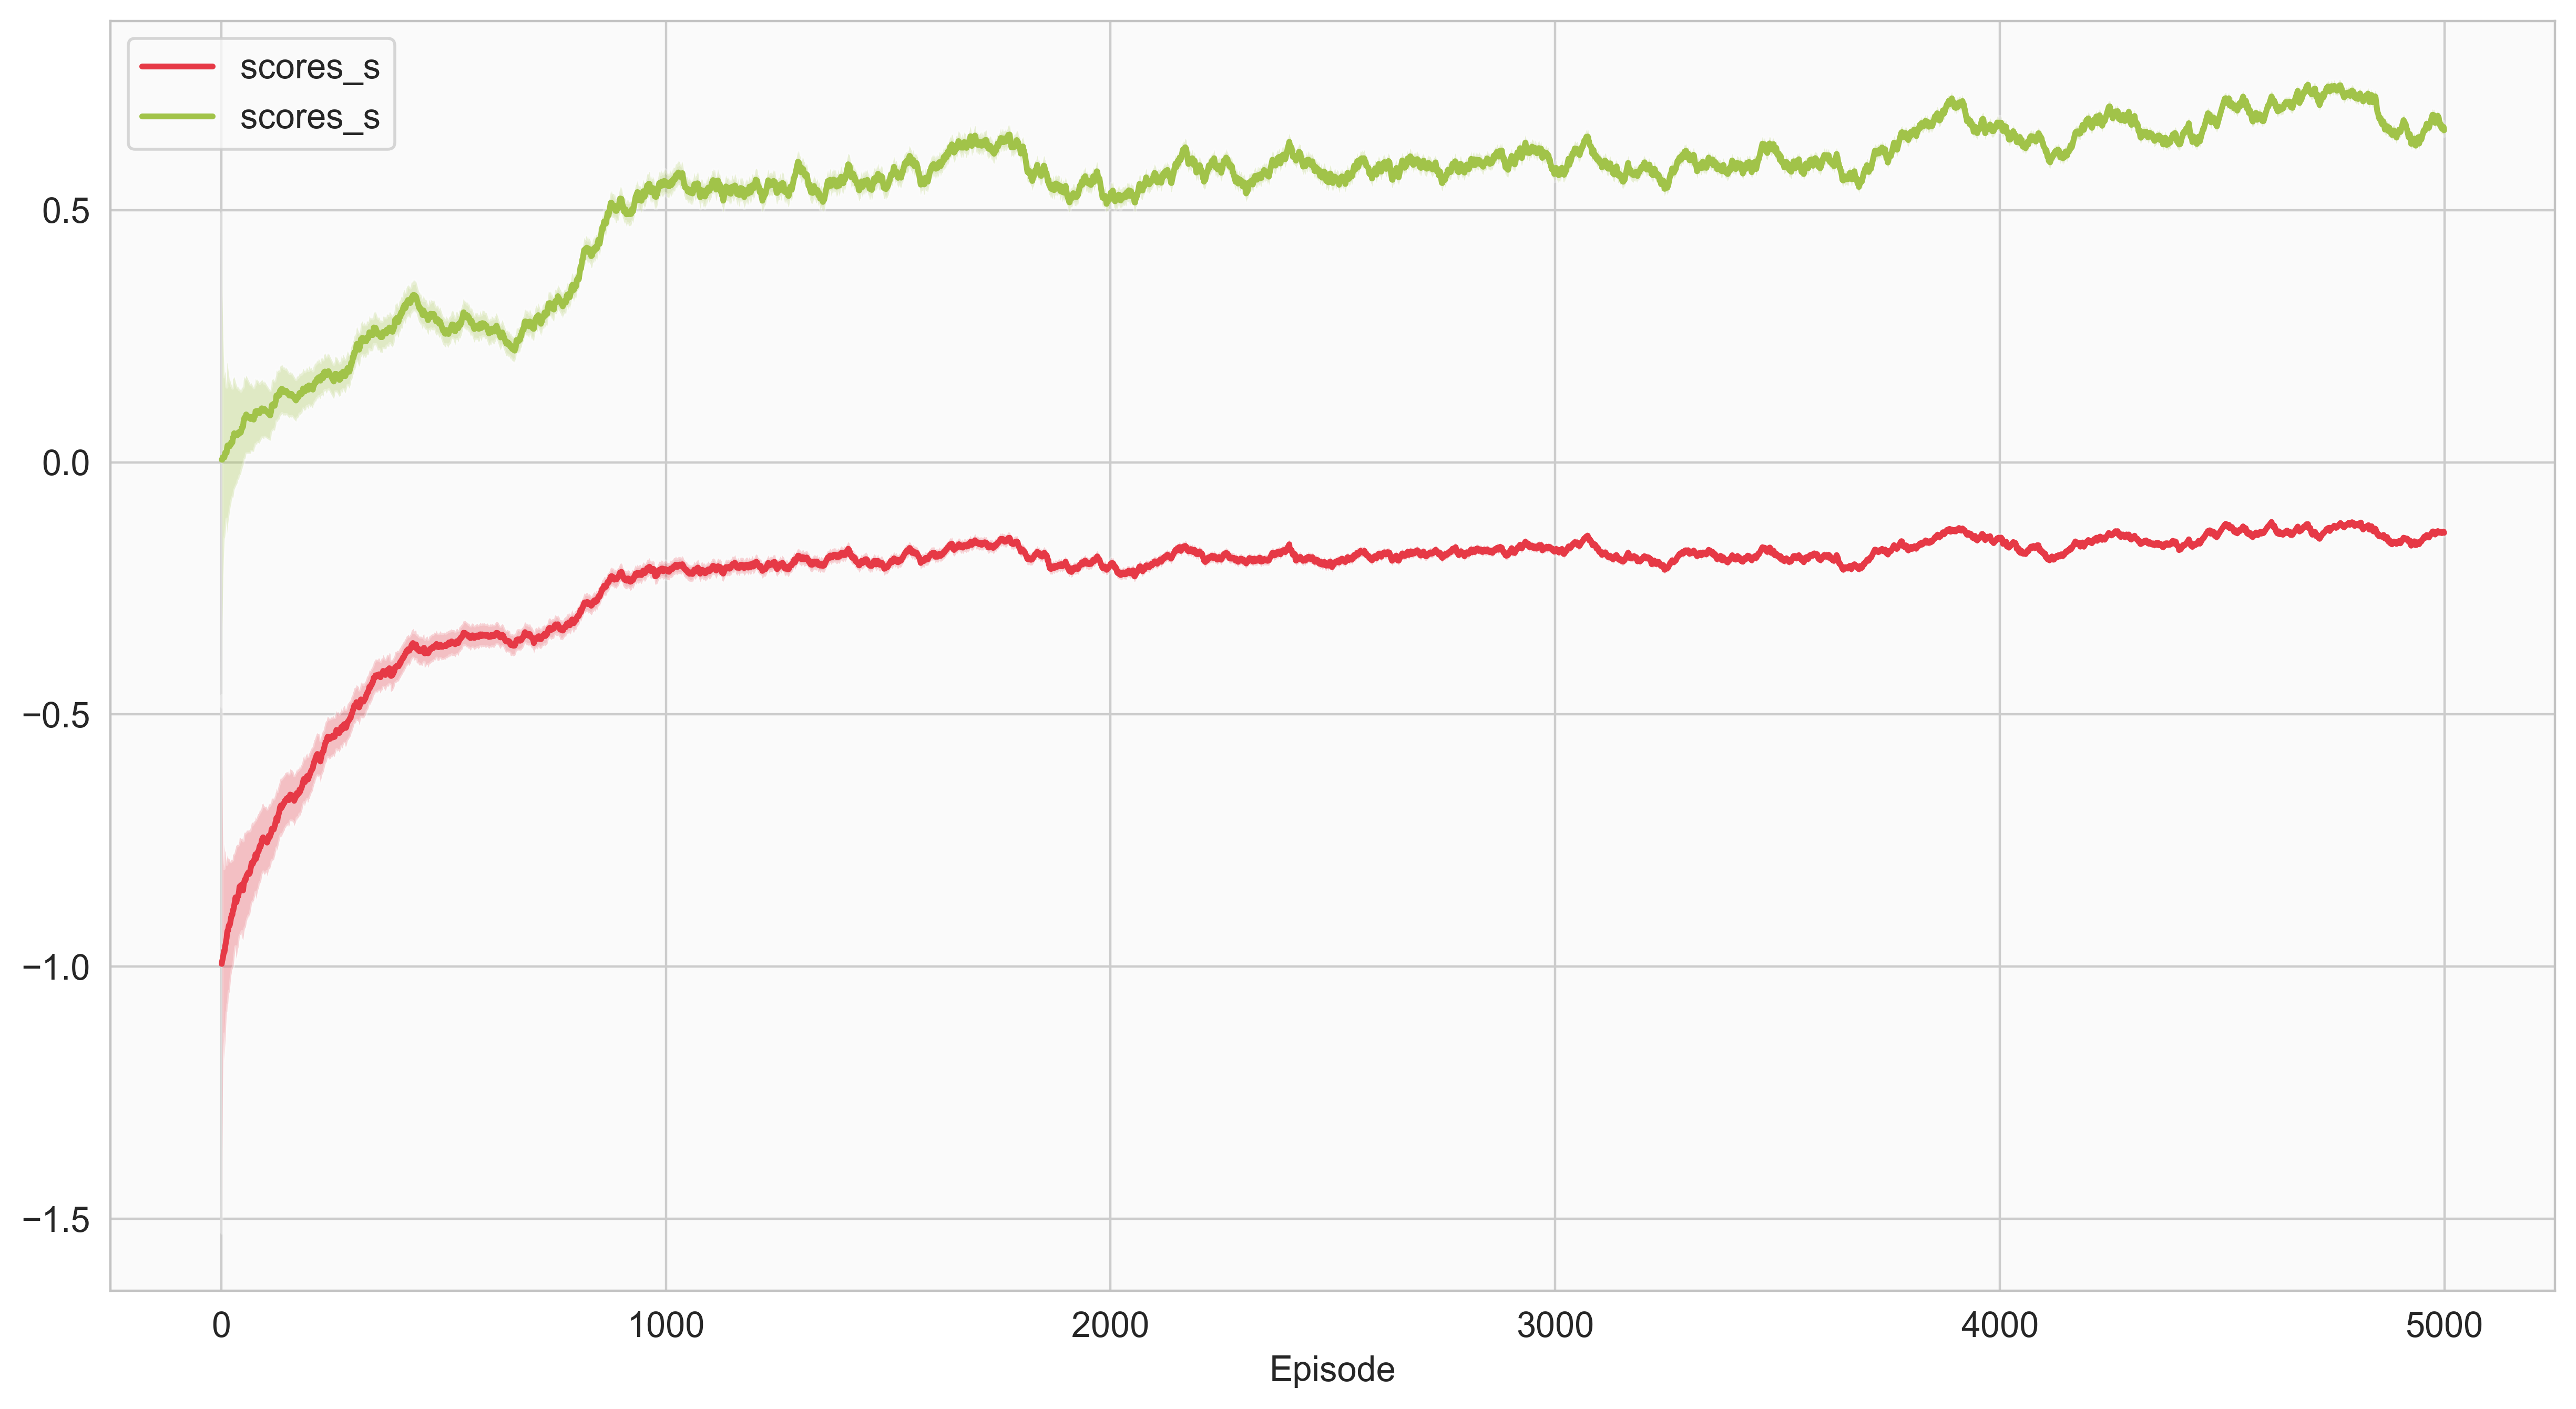

In [61]:
# Plot scores

def plot_scores(data, data_s, confidence=0.95, st=1):
    n = len(data)
    conf_inter = [t.ppf((1 + confidence) / 2, n - 1) * sem(data[:i+1]) for i in range(st,n)]
    conf_inter = np.array(conf_inter)
    plt.plot(np.arange(n-st)+st,data_s[st:n], label='scores_s')
    plt.fill_between(np.arange(n-st)+st, data_s[st:n] - conf_inter, data_s[st:n] + conf_inter, alpha=0.3)

plt.figure()
plot_scores(scores, scores_s)
plot_scores(completions, completions_s)
plt.xlabel('Episode')
plt.legend()
plt.show()

	✅ Eval: score -0.184 done 65.0%


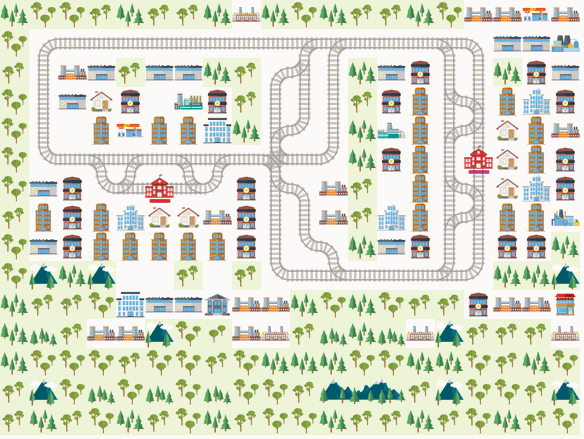

In [65]:
# Test the policy
n_test = 10
scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params)

# Get argmin of scores
worst_seed = seeds[np.argmin(scores)]
best_seed = seeds[np.argmax(scores)]

# Test the policy on a seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=worst_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')

### LSTM QNetwork

Notes : increased \epsilon, reduced number of layers processing the attributes, increased lr, increased tau and decresed period of updating target network, added softmax choice of action for wider exploration even when the policy gets stuck, decreased tree_pred_path_depth to 300

In [86]:
policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=32, gamma=0.99, tau=2e-3, 
                                 lr=3e-3, update_every=2, use_gpu=True)

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2,
    obs_builder_object=TreeCutils(fp.num_tree_obs_nodes, fp.tree_pred_path_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

model = LSTMQNetwork()
policy = DeepPolicy(model, policy_params)

## Test the policy output
obs, info = env.reset()

from observation_utils import normalize_cutils, get_features

obs_list = normalize_cutils(obs, env)

features = get_features(obs_list)
logits = model(*features)[0][0]
logits = logits.squeeze().detach().numpy()

Using CPU


In [87]:
# Train the policy
obs_params = {
    "observation_tree_depth": 3,
    "observation_radius": 10,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.03,
    "eps_decay": 0.996,
    "n_episodes": 1000,
    "checkpoint_interval": 100,
    "n_eval_episodes": 1,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
    "LSTM" : True
}

scores, scores_s, completions, completions_s = train_agent(env, policy, train_params, obs_params, log=True)


💾 Replay buffer status: 0/100000 experiences

🚉 Training 2 trains on 20x15 grid for 1000 episodes, evaluating on 1 episodes every 100 episodes.

🚂 Episode 0	 🏆 Score: -0.511 Avg: -0.995	 💯 Done: 0.00% Avg: 0.00%	 🎲 Epsilon: 0.996 	 🔀 Action Probs: ↻ 0.400 ← 0.050 ↑ 0.150 → 0.150 ◼ 0.250  

ValueError: The number of weights does not match the population

In [74]:
data = {
    "scores": scores,
    "scores_s": scores_s,
    "completions": completions,
    "completions_s": completions_s,
}

with open("saved_scores/scores_lstm.pkl", "wb") as f:
    pickle.dump(data, f)

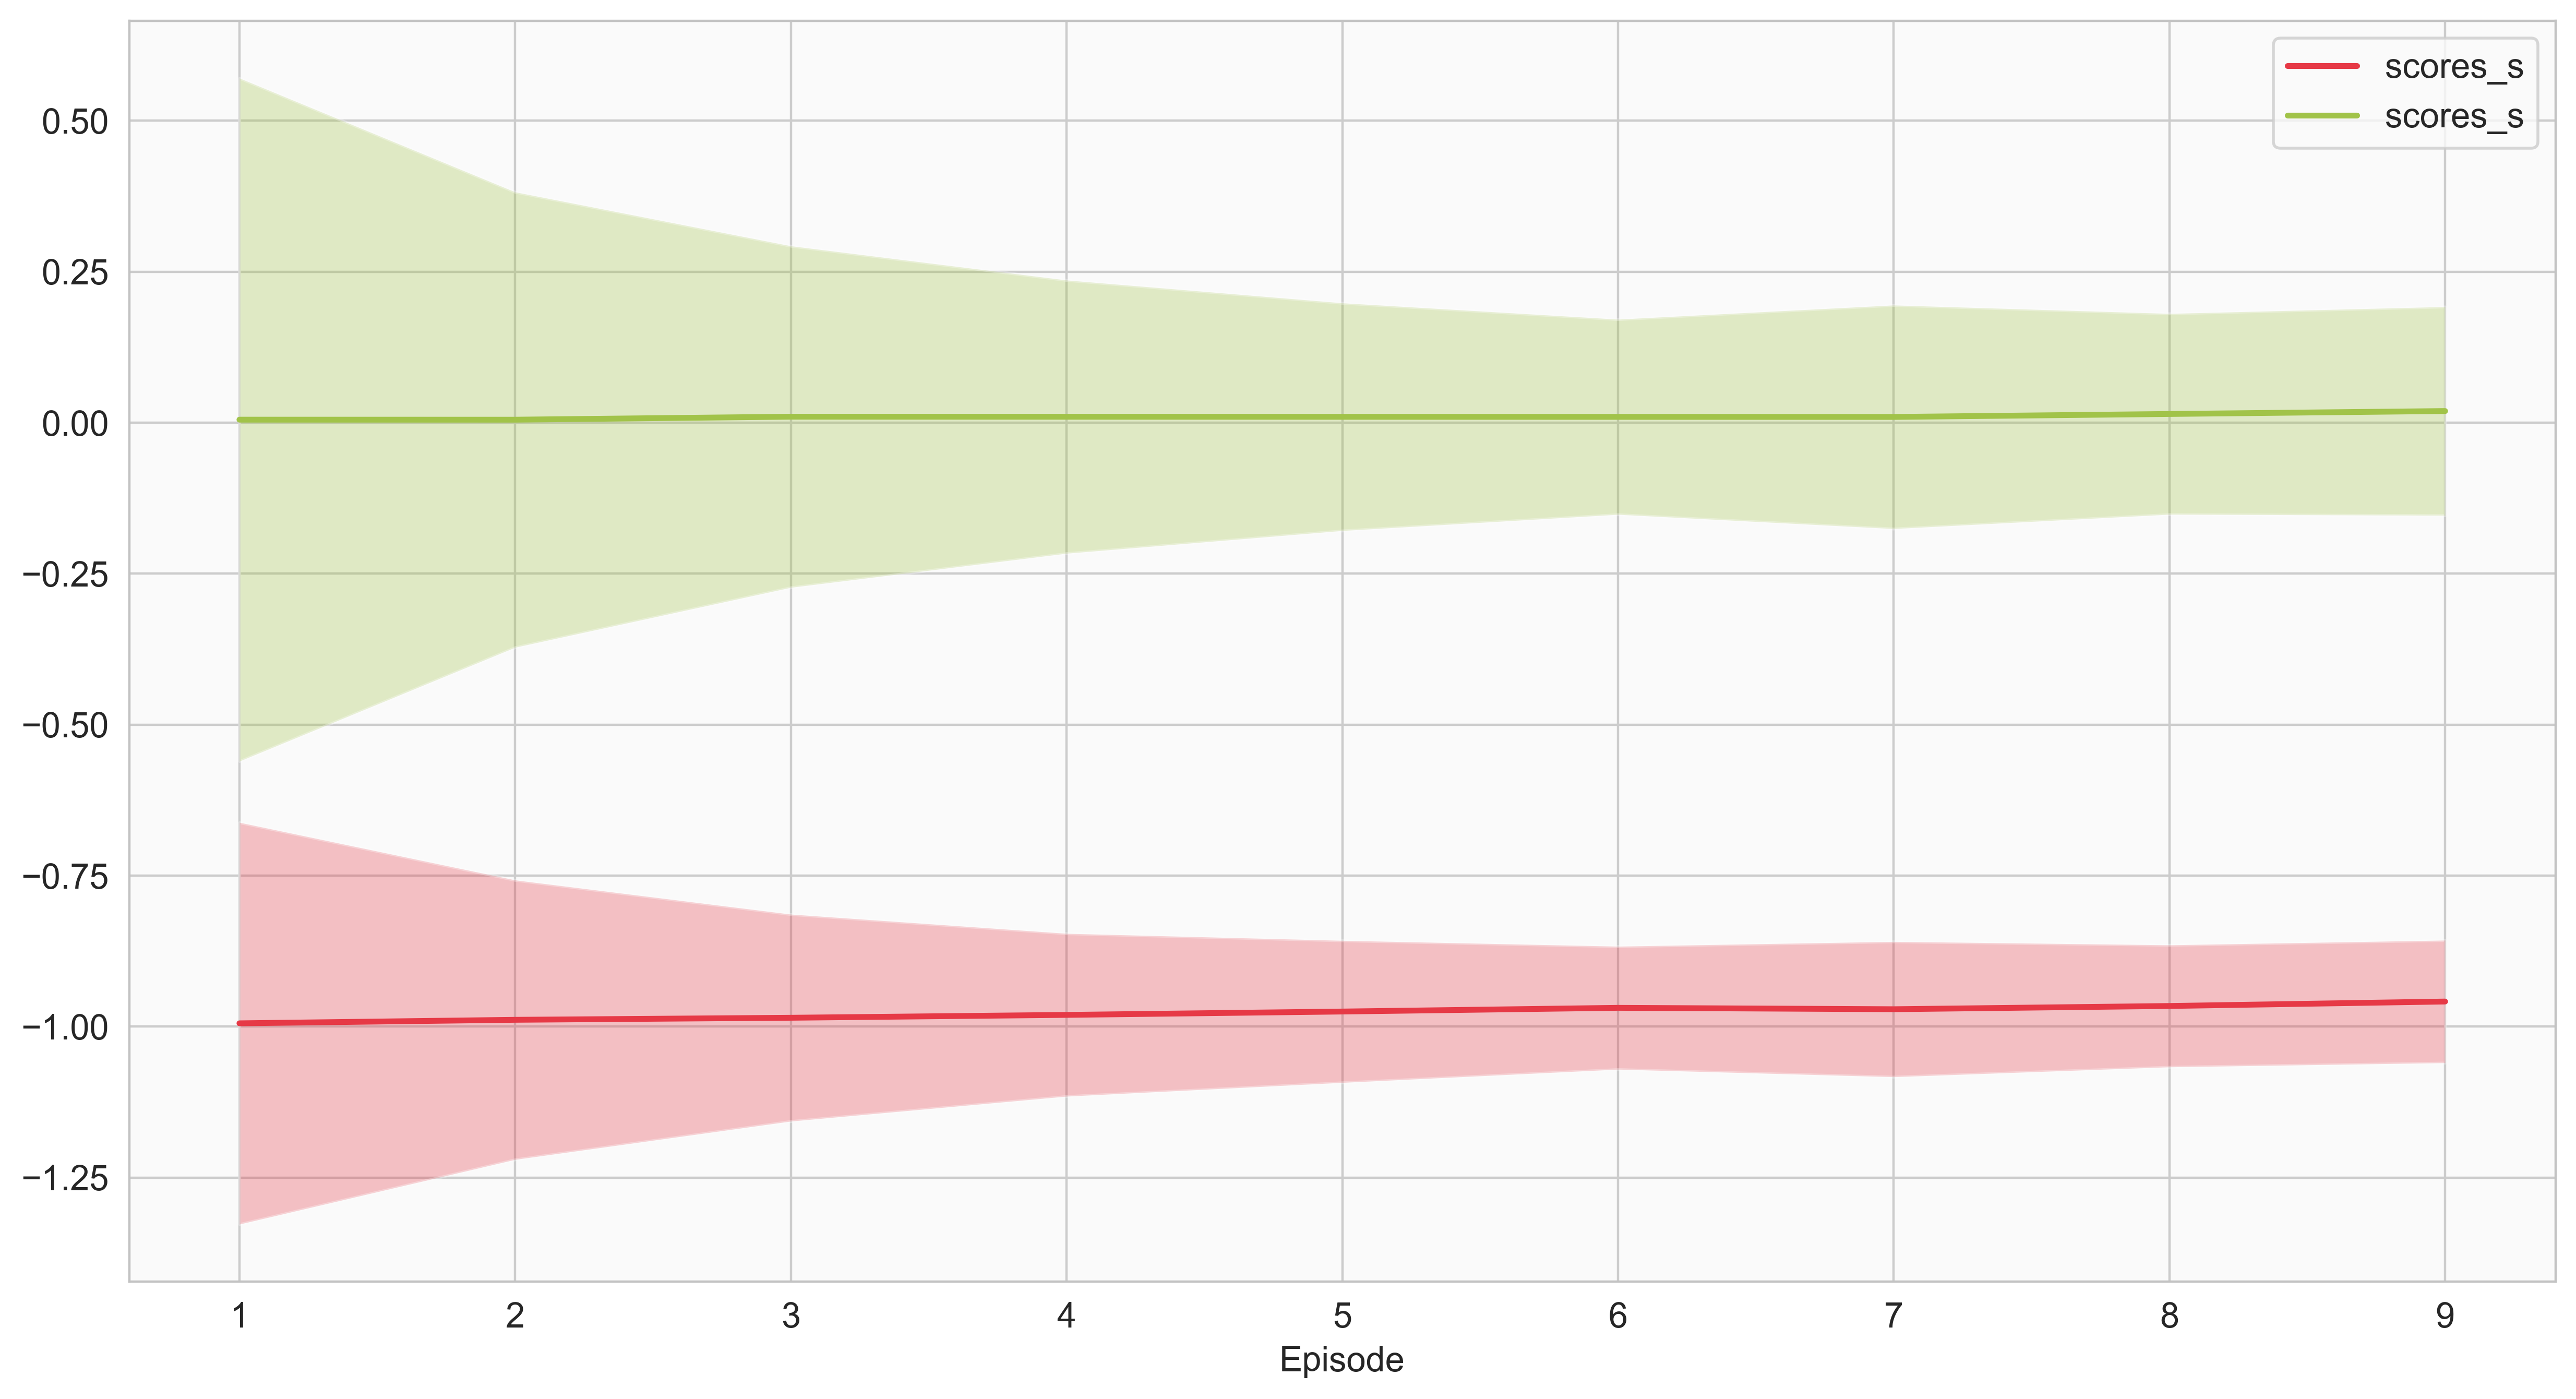

In [76]:
# Plot scores

def plot_scores(data, data_s, confidence=0.95, st=1):
    n = len(data)
    conf_inter = [t.ppf((1 + confidence) / 2, n - 1) * sem(data[:i+1]) for i in range(st,n)]
    conf_inter = np.array(conf_inter)
    plt.plot(np.arange(n-st)+st,data_s[st:n], label='scores_s')
    plt.fill_between(np.arange(n-st)+st, data_s[st:n] - conf_inter, data_s[st:n] + conf_inter, alpha=0.3)

plt.figure()
plot_scores(scores, scores_s)
plot_scores(completions, completions_s)
plt.xlabel('Episode')
plt.legend()
plt.show()

	✅ Eval: score -0.535 done 18.5%


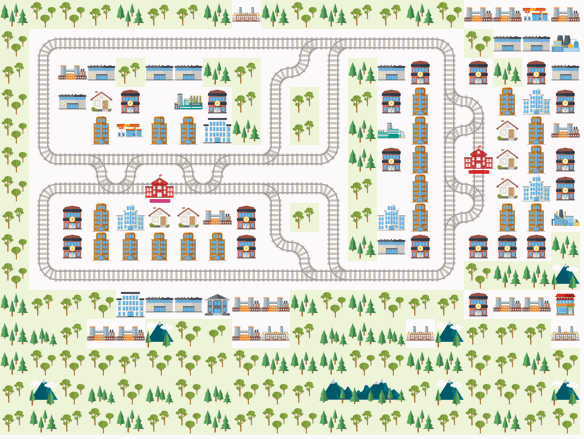

In [ ]:
# Test the policy
n_test = 10
scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params, LSTM=True)

# Get argmin of scores
worst_seed = seeds[np.argmin(scores)]
best_seed = seeds[np.argmax(scores)]

# Test the policy on the best seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=worst_seed, real_time_render=False, force_gif=True, LSTM=True)
env_renderer.make_gif('test')

### DuelingQNetwork with Transformer

In [90]:

policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=32, gamma=0.995, tau=4e-3, 
                                 lr=6e-4, update_every=10, use_gpu=True)
observation_tree_depth = 4
observation_radius = 12
observation_max_path_depth = 20

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2,
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes

# Test the policy output
obs, info = env.reset()

n_agents = env.get_num_agents()

model = DuelingTrans(state_size, action_size=5)
policy = DeepPolicy(model, policy_params)

# Get the state by normalizing the observation
agent_obs = [None] * env.get_num_agents()
for agent in env.get_agent_handles():
    if obs[agent]:
        agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)

full_obs = np.vstack(agent_obs)

# Test the policy (debugging)
actions = policy.act_centralized(full_obs, eps=0)

Using CPU


In [114]:
# Train the policy
obs_params = {
    "observation_tree_depth": observation_tree_depth,
    "observation_radius": observation_radius,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.05,
    "eps_decay": 0.997,
    "n_episodes": 1500,
    "checkpoint_interval": 50,
    "n_eval_episodes": 1,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
    "centralized": True,
}

train_agent(env, policy, train_params, obs_params)


💾 Replay buffer status: 11715/100000 experiences

🚉 Training 2 trains on 20x15 grid for 1500 episodes, evaluating on 1 episodes every 50 episodes.

🚂 Episode 0	 🏆 Score: -0.621 Avg: -0.996	 💯 Done: 50.00% Avg: 0.50%	 🎲 Epsilon: 0.997 	 🔀 Action Probs: ↻ 0.188 ← 0.250 ↑ 0.188 → 0.188 ◼ 0.188  	✅ Eval: score -0.485 done 50.0%
	🔍 Evaluation score: -0.485 done: 50.0%
🚂 Episode 50	 🏆 Score: 0.000 Avg: -0.821	 💯 Done: 100.00% Avg: 10.19%	 🎲 Epsilon: 0.858 	 🔀 Action Probs: ↻ 0.154 ← 0.154 ↑ 0.077 → 0.462 ◼ 0.154  	✅ Eval: score -0.196 done 50.0%
	🔍 Evaluation score: -0.196 done: 50.0%
🚂 Episode 100	 🏆 Score: -1.136 Avg: -0.696	 💯 Done: 0.00% Avg: 17.44%	 🎲 Epsilon: 0.738 	 🔀 Action Probs: ↻ 0.071 ← 0.857 ↑ 0.000 → 0.000 ◼ 0.071   	✅ Eval: score -0.446 done 0.0%
	🔍 Evaluation score: -0.446 done: 0.0%
🚂 Episode 150	 🏆 Score: -0.443 Avg: -0.613	 💯 Done: 0.00% Avg: 23.74%	 🎲 Epsilon: 0.635 	 🔀 Action Probs: ↻ 0.143 ← 0.000 ↑ 0.286 → 0.429 ◼ 0.143  	✅ Eval: score -0.439 done 50.0%
	🔍 Evaluation 

In [ ]:
# Get the state by normalizing the observation
agent_obs = [None] * env.get_num_agents()
for agent in env.get_agent_handles():
    if obs[agent]:
        agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)

full_obs = np.vstack(agent_obs)

# Test the policy (debugging)
actions = policy.act_centralized(full_obs, eps=0)

In [107]:
state = torch.from_numpy(full_obs).float().unsqueeze(0)
action_values = policy.model(state)
feature_embeddings = policy.model.feature_embedding(state)
transformer_embeddings = policy.model.transformer(feature_embeddings)

actor = policy.model.actor_net(torch.cat([feature_embeddings, transformer_embeddings], dim=-1))
critic = policy.model.critic_net(torch.cat([feature_embeddings, transformer_embeddings], dim=-1))

In [113]:
# check out some weights

policy.model.actor_net[0].weight

Parameter containing:
tensor([[ 0.0039, -0.0387,  0.0327,  ..., -0.0147,  0.0200,  0.0314],
        [-0.0309,  0.0180,  0.0512,  ...,  0.0389,  0.0436, -0.0300],
        [-0.0587,  0.0250,  0.0474,  ...,  0.0499, -0.0393, -0.0251],
        ...,
        [ 0.0345, -0.0074,  0.0112,  ..., -0.0415,  0.0125,  0.0309],
        [-0.0419, -0.0532,  0.0038,  ..., -0.0233,  0.0121,  0.0566],
        [-0.0124, -0.0234, -0.0619,  ...,  0.0401, -0.0721, -0.0185]],
       requires_grad=True)

### LSTM with Transformer

In [69]:
policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=32, gamma=0.99, tau=1e-3, 
                                 lr=5e-4, update_every=4, use_gpu=True)

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2,
    obs_builder_object=TreeCutils(fp.num_tree_obs_nodes, fp.tree_pred_path_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

model = LSTMTrans()
policy = DeepPolicy(model, policy_params)

## Test the policy output
obs, info = env.reset()

obs_list = normalize_cutils(obs, env)

individual_features = get_features([individual_from_obs_list(obs_list[0], 0)])

features = get_features(obs_list)
logits = model(*features)[0]
logits_indiv = model(*individual_features)[0]
logits = logits.squeeze().detach().numpy()

Using CPU


In [70]:
logits

array([[0.21285053, 0.18757582, 0.2051831 , 0.2001833 , 0.19420725],
       [0.21285194, 0.18756784, 0.20514596, 0.20022137, 0.19421296]],
      dtype=float32)

In [71]:
# Train the policy
obs_params = {
    "observation_tree_depth": 3,
    "observation_radius": 10,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 0.995,
    "n_episodes": 400,
    "checkpoint_interval": 50,
    "n_eval_episodes": 1,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
    "LSTM" : True
}

train_agent(env, policy, train_params, obs_params)


💾 Replay buffer status: 0/100000 experiences

🚉 Training 2 trains on 20x15 grid for 400 episodes, evaluating on 1 episodes every 50 episodes.

🚂 Episode 0	 🏆 Score: -0.588 Avg: -0.996	 💯 Done: 50.00% Avg: 0.50%	 🎲 Epsilon: 0.995 	 🔀 Action Probs: ↻ 0.250 ← 0.062 ↑ 0.375 → 0.125 ◼ 0.188  	✅ Eval: score -0.500 done 0.0%
	🔍 Evaluation score: -0.500 done: 0.0%
🚂 Episode 50	 🏆 Score: -0.478 Avg: -0.816	 💯 Done: 50.00% Avg: 9.62%	 🎲 Epsilon: 0.774 	 🔀 Action Probs: ↻ 0.294 ← 0.294 ↑ 0.059 → 0.176 ◼ 0.176  	✅ Eval: score -0.522 done 0.0%
	🔍 Evaluation score: -0.522 done: 0.0%
🚂 Episode 100	 🏆 Score: -0.439 Avg: -0.751	 💯 Done: 50.00% Avg: 14.41%	 🎲 Epsilon: 0.603 	 🔀 Action Probs: ↻ 0.474 ← 0.053 ↑ 0.158 → 0.158 ◼ 0.158  	✅ Eval: score -0.439 done 50.0%
	🔍 Evaluation score: -0.439 done: 50.0%
🚂 Episode 150	 🏆 Score: -0.574 Avg: -0.671	 💯 Done: 50.00% Avg: 15.19%	 🎲 Epsilon: 0.469 	 🔀 Action Probs: ↻ 0.571 ← 0.095 ↑ 0.095 → 0.095 ◼ 0.143  	✅ Eval: score -0.522 done 0.0%
	🔍 Evaluation score: -

KeyboardInterrupt: 

In [ ]:
# Test the policy
n_test = 100
scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params)

# Get argmin of scores
worst_seed = seeds[np.argmin(scores)]
best_seed = seeds[np.argmax(scores)]

# Test the policy on the best seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=best_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')